# Milestone 3: Deep Dive

### 3.1 : Load Essential Libraries

In [ ]:
import re
import pandas as pd
import sqlite3
%reload_ext sql
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer

conn = sqlite3.connect("congressional_tweets.db")
%sql sqlite:///congressional_tweets.db


### 3.2 : TF-IDF for Word Frequency / Theme Analysis

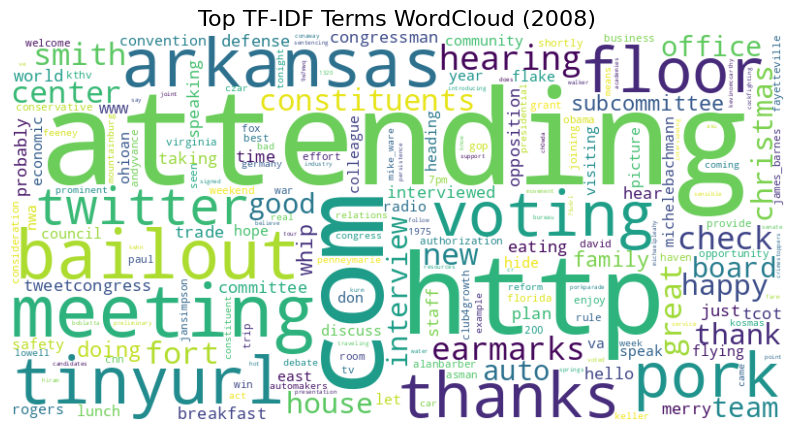

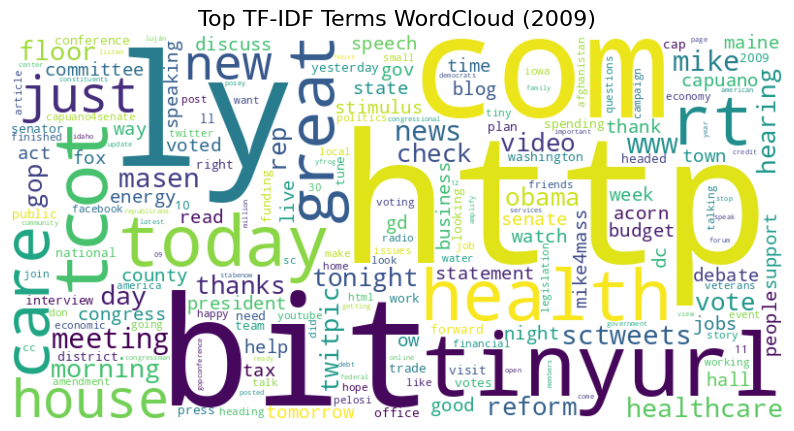

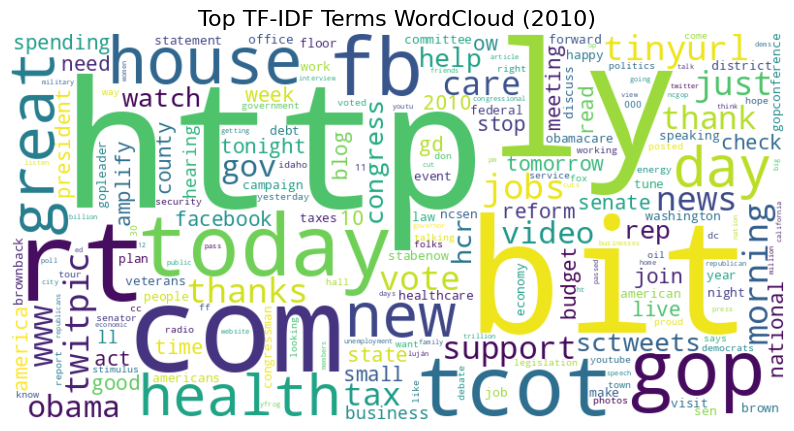

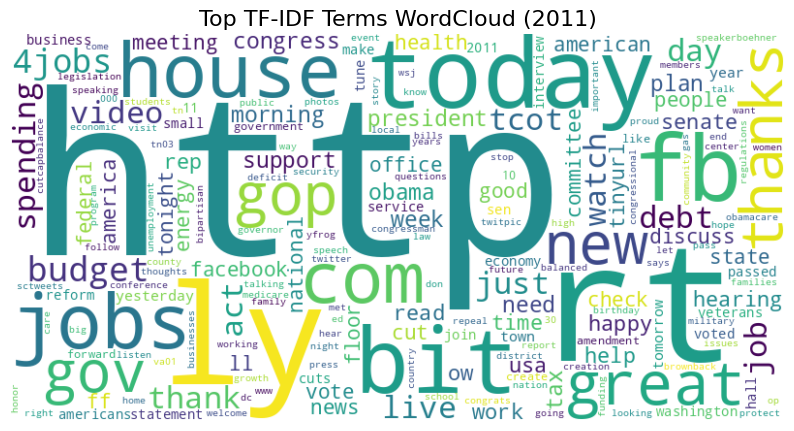

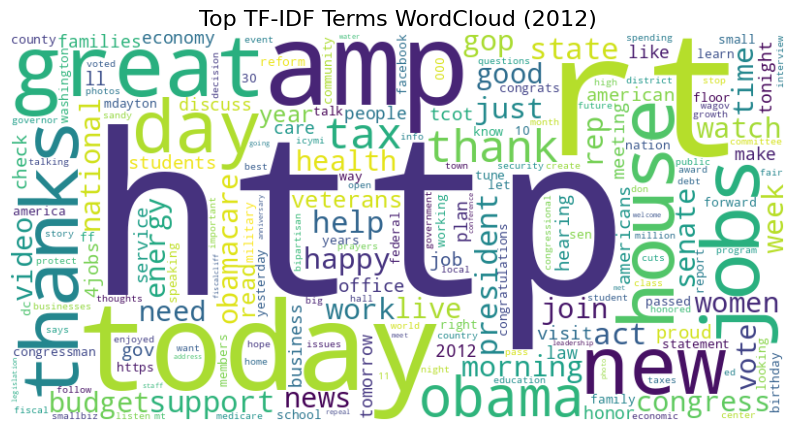

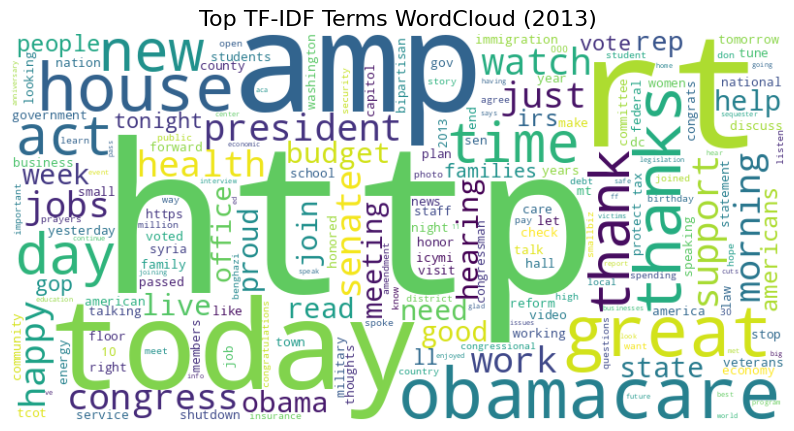

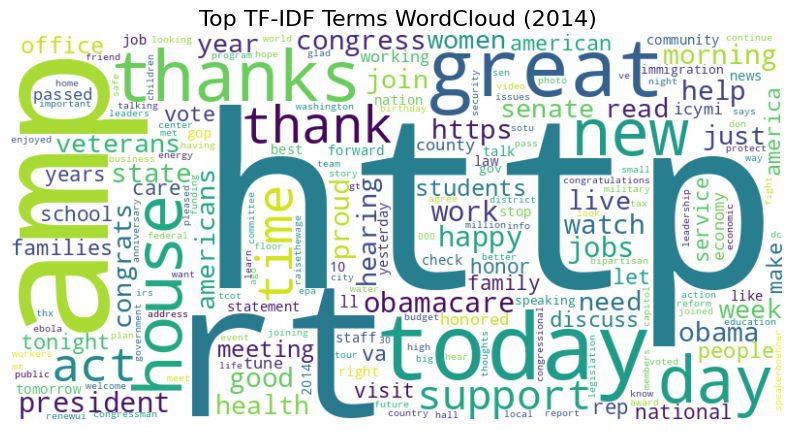

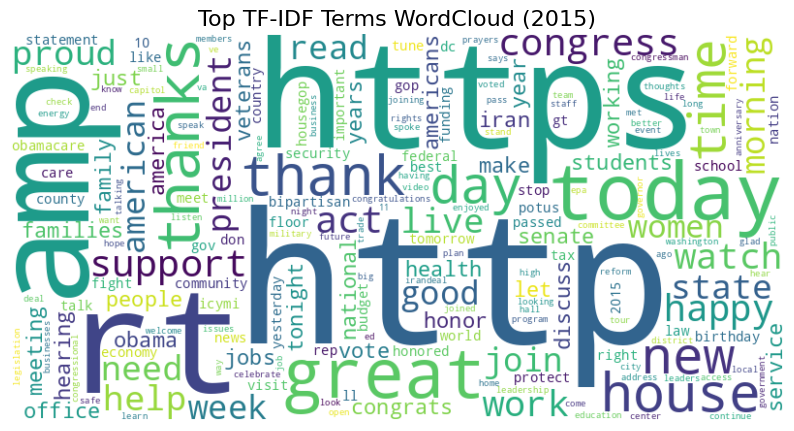

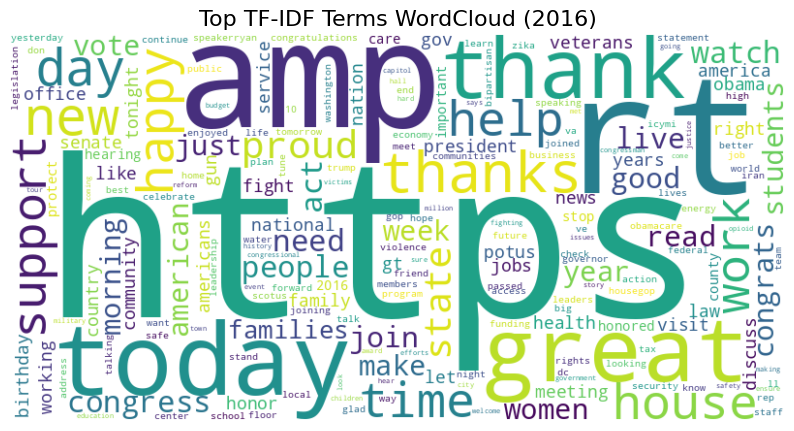

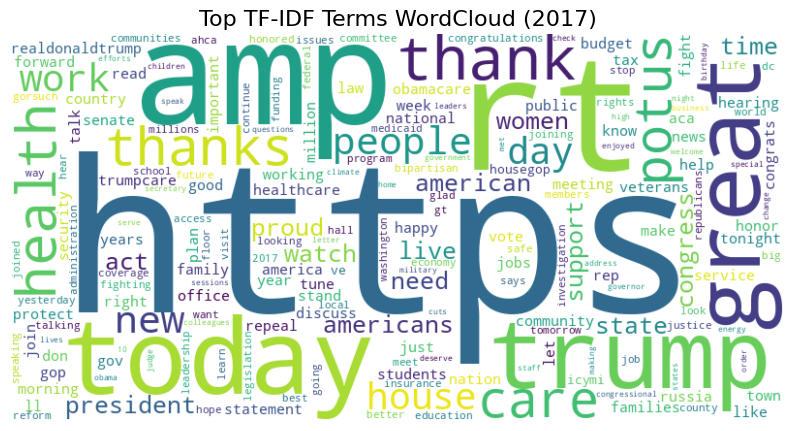

In [ ]:

query_texts = """
SELECT 
    id,        
    text,
    created_at        
FROM tweets
WHERE text IS NOT NULL
  AND TRIM(text) != '';
"""

df_texts = pd.read_sql_query(query_texts, conn)
def clean_text(text):
    text = re.sub(r"http\S+|https\S+", "", text)  # Remove http and https links
    return text

df_texts['clean_text'] = df_texts['text'].apply(clean_text)

# Convert to datetime
df_texts["created_at"] = pd.to_datetime(df_texts["created_at"])
df_texts["year"] = df_texts["created_at"].dt.year

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)

for year, group in df_texts.groupby("year"):
    X_tfidf = vectorizer.fit_transform(group['clean_text'])
    tfidf_df = pd.DataFrame(
        X_tfidf.toarray(), 
        columns=vectorizer.get_feature_names_out(), 
        index=group["id"]
    )

    # Sum TF-IDF scores
    term_scores = tfidf_df.sum(axis=0).sort_values(ascending=False)

    # Generate WordCloud weighted by TF-IDF scores
    wc = WordCloud(width=800, height=400, 
                   background_color="white",
                   colormap="viridis").generate_from_frequencies(term_scores.to_dict())

    plt.figure(figsize=(10,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Top TF-IDF Terms WordCloud ({year})", fontsize=16)
    plt.show()

### 3.2 : Sentiment Analysis

In [ ]:
df_texts["sentiment"] = df_texts["text"].apply(lambda x: TextBlob(x).sentiment.polarity)
print(df_texts[["text", "sentiment"]].head(10))


# Plot sentiment distribution
plt.figure(figsize=(10,6))
plt.hist(df_texts["sentiment"], bins=30, color="skyblue", edgecolor="black")
plt.title("Sentiment Distribution of Tweets", fontsize=16)
plt.xlabel("Sentiment Polarity", fontsize=14)
plt.ylabel("Tweet Count", fontsize=14)
plt.grid(axis="y", alpha=0.75)
plt.show()  

# Average sentiment over time
df_texts.set_index("created_at", inplace=True)
sentiment_over_time = df_texts["sentiment"].resample("M").mean()
plt.figure(figsize=(12,6))
plt.plot(sentiment_over_time.index, sentiment_over_time.values, marker='o', linestyle='-')
plt.title("Average Tweet Sentiment Over Time", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Average Sentiment Polarity", fontsize=14)
plt.grid()(True)
plt.show()
